In [1]:
import pandas as pd
from fastai.vision.all import *

In [17]:
# This patch is to display epoch results while using Visual Studio Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

সাধারন ক্লাসিফিকেশন সমস্যাগুলোতে একটি ছবিতে এক ধরনের একটিই বস্তু থাকে যা আমরা ক্লাসিফাই করতে চাই। যেমন, আমরা যাদি একটি মডেল বানাতে চাই যা কুকুর এবং বিড়ালের ছবি ক্লাসিফাই করতে পারে, তাহলে প্রত্যেক ছবিতে শুধু একটি কুকুর অথবা একটি বিড়ালই থাকবে। এমনকি কোন ছবিতে যদি কোনটিই না থাকে, তবুও আমাদের মডেল ছবিটিকে কুকুর অথবা বিড়াল হিসেবে ক্লাসিফাই করবে। অন্যদিকে, মাল্টি-লেবেল ক্লাসিফিকেশনে আমরা একটি ছবিতে এক বা একাধিক ধরনের ভিন্ন ভিন্ন বস্তু খুঁজে বের করি। আবার এমনও হতে পারে যে ছবিতে কোন বস্তুই নেই।

মাল্টি-লেবেল ক্লাসিফিকেশনের জন্য আমরা `PASCAL` ডাটাসেটটি ব্যবহার করব। এই ডাটাসেটটি ইমেজনেটের মত ফোল্ডার বা ফাইলের নাম দিয়ে সাজানো নয়। বরং একটি সি,এস,ভি, ফাইলে প্রত্যেক ছবির ফাইলের নাম এবং এর ক্লাস দেয়া থাকে।

In [2]:
path = untar_data(URLs.PASCAL_2007)

খেয়াল কর, লেবেলস কলামে কোন কোন ছবির জন্য একাধিক লেবেল আছে। একাধিক লেবেল থাকলে তা স্পেইস দিয়ে আলাদা করা আছে।

In [3]:
metadata = pd.read_csv(path/'train.csv')
metadata.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


`PyTorch` ডাটা নিয়ে কাজ করার জন্য দুটি ক্লাস ব্যবহার করে। একটি হল `Dataset` যা মুলত ইন্ডিপেন্ডেন্ট এবং ডিপেন্ডেন্ট ভ্যারিয়েবলের একটি করে `tuple` সরবরাহ করে। আরেকটি হল `DataLoader` যা ইন্ডিপেন্ডেন্ট এবং ডিপেন্ডেন্ট ভ্যারিয়েবলের একটি করে মিনি ব্যাচ সরবরাহ করে। 

In [4]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [5]:
dblock = DataBlock(
    blocks= (ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x = get_x,
    get_y = get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)

In [6]:
dls = dblock.dataloaders(metadata)

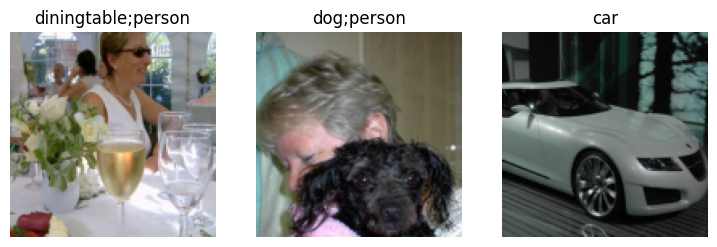

In [7]:
dls.show_batch(nrows=1, ncols=3)

In [8]:
learn = vision_learner(dls, resnet18)

c:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\musab/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:09<00:00, 5.10MB/s]


In [9]:
x, y = dls.train.one_batch()
activations = learn.model.cuda()(x)
activations.shape

torch.Size([64, 20])

In [10]:
activations[0]

TensorImage([-0.3700,  3.2741,  0.1542, -1.3794, -1.0576, -1.4770, -0.4821,
              1.2593, -0.7277,  0.9163,  2.3092, -4.0251,  1.5294, -4.2756,
              0.4536, -0.1623,  0.2826, -0.9426, -2.8374, -3.4963],
            device='cuda:0', grad_fn=<AliasBackward0>)

In [11]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

In [12]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

In [13]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11778111010789871,0.9176692366600037]

In [14]:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9489)

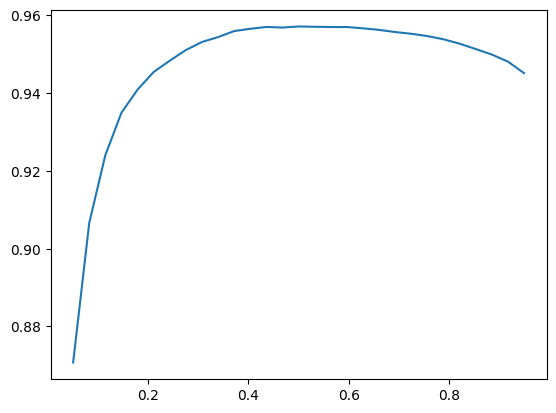

In [15]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Regression
We will use the Biwi Kinect Head Pose dataset for this section. We’ll begin by downloading the dataset as usual.

In [16]:
path = untar_data(URLs.BIWI_HEAD_POSE)

There are $24$ directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding .obj file for each (we won’t need them here).

In [21]:
for p in path.ls():
    print(p)

C:\Users\musab\.fastai\data\biwi_head_pose\01
C:\Users\musab\.fastai\data\biwi_head_pose\01.obj
C:\Users\musab\.fastai\data\biwi_head_pose\02
C:\Users\musab\.fastai\data\biwi_head_pose\02.obj
C:\Users\musab\.fastai\data\biwi_head_pose\03
C:\Users\musab\.fastai\data\biwi_head_pose\03.obj
C:\Users\musab\.fastai\data\biwi_head_pose\04
C:\Users\musab\.fastai\data\biwi_head_pose\04.obj
C:\Users\musab\.fastai\data\biwi_head_pose\05
C:\Users\musab\.fastai\data\biwi_head_pose\05.obj
C:\Users\musab\.fastai\data\biwi_head_pose\06
C:\Users\musab\.fastai\data\biwi_head_pose\06.obj
C:\Users\musab\.fastai\data\biwi_head_pose\07
C:\Users\musab\.fastai\data\biwi_head_pose\07.obj
C:\Users\musab\.fastai\data\biwi_head_pose\08
C:\Users\musab\.fastai\data\biwi_head_pose\08.obj
C:\Users\musab\.fastai\data\biwi_head_pose\09
C:\Users\musab\.fastai\data\biwi_head_pose\09.obj
C:\Users\musab\.fastai\data\biwi_head_pose\10
C:\Users\musab\.fastai\data\biwi_head_pose\10.obj
C:\Users\musab\.fastai\data\biwi_head_po

Inside the subdirectories, we have different frames. Each of them comes with an image `(_rgb.jpg)` and a pose file `(_pose.txt)`.

In [22]:
for p in (path/'01').ls():
    print(p)

C:\Users\musab\.fastai\data\biwi_head_pose\01\depth.cal
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00003_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00003_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00004_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00004_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00005_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00005_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00006_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00006_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00007_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00007_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00008_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00008_rgb.jpg
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00009_pose.txt
C:\Users\musab\.fastai\data\biwi_head_pose\01\frame_00009_rgb.jpg
C:\Users\musa

We can easily get all the image files recursively with `get_image_files`, and then write a function that converts an image filename to its associated pose file.

In [23]:
img_files = get_image_files(path)

def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])
Path('13/frame_00349_pose.txt')

Path('13/frame_00349_pose.txt')

(480, 640)


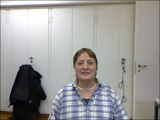

In [24]:
im = PILImage.create(img_files[0])
print(im.shape)
im.to_thumb(160)

In [25]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [26]:
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

We can pass this function to DataBlock as `get_y`, since it is responsible for labeling each item. We’ll resize the images to half their input size, to speed up training a bit. 

One important point to note is that we should not just use a random splitter. The same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn’t seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns True for just one person, resulting in a validation set containing just that person’s images.

The only other difference from the previous data block examples is that the second block is a PointBlock. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images. We’re not aware of other libraries (except for fastai) that automatically and correctly apply data augmentation to coordinates. So, if
you’re working with another library, you may need to disable data augmentation for these kinds of problems.

In [27]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

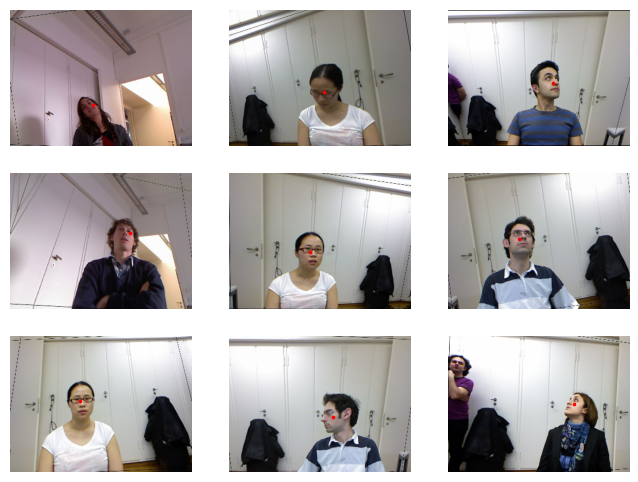

In [28]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

As well as looking at the batch visually, it’s a good idea to also look at the underlying tensors (especially as a student; it will help clarify your understanding of what your model is really seeing)

In [29]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [30]:
learn = vision_learner(dls, resnet18, y_range=(-1, 1))

c:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0020892962347716093)

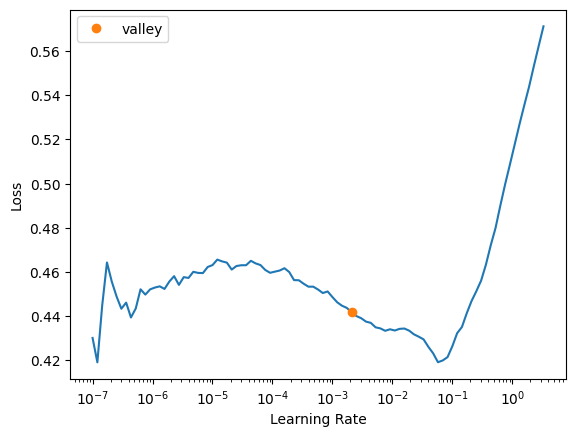

In [31]:
learn.lr_find()

In [32]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.047445,0.017673,04:28
1,0.007347,0.001391,03:15
2,0.003330,0.002276,02:44
3,0.002234,0.000555,02:59
4,0.001788,0.000970,03:15


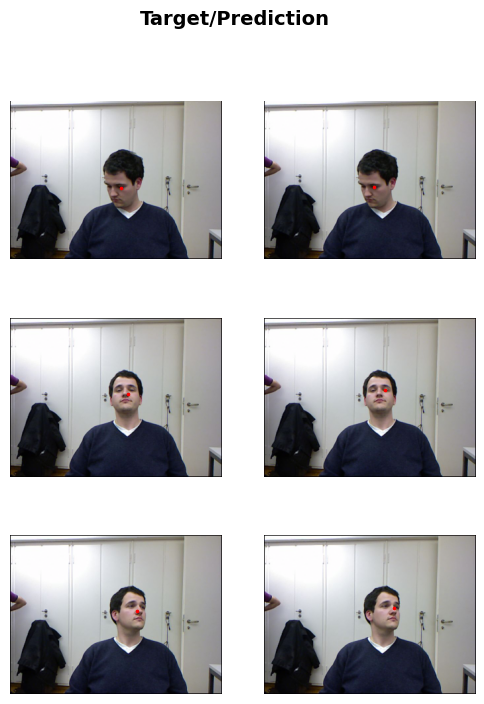

In [33]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))